<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: Calwebb_Image3, Resample step

<span style="color:red"> **Instruments Affected**</span>: FGS, MIRI, NIRCam, NIRISS, NIRSpec 

Tested on MIRI Simulated data

### Table of Contents
<div style="text-align: left"> 

<br>  [Introduction](#intro_ID) <br> [Run JWST Pipelines](#pipeline_ID) <br> [Imports](#imports_ID) <br> [Find Stars in Image and Determine their Coordinates](#runscript_ID) <br> [Compare RA and Dec to expected Values](#residual_ID) <br> [About This Notebook](#about_ID) <br>


</div>

<a id="intro_ID"></a>
# Introduction


This test is designed to test the resample step in the calwebb_image3 pipeline. At the end of the calwebb_image3 pipeline, the set of files defined in an association table will be distortion corrected and combined. Resample is the step that applies the distortion correction using the drizzling algorithm (as defined in the DrizzlePac handbook) and combines the listed files. For more information on the pipeline step visit the links below. 

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/resample/main.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/resample

The data for this test were created with the MIRI Data Simulator, and the documentation for that code can be found here: http://miri.ster.kuleuven.be/bin/view/Public/MIRISim_Public


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Image+Combination


### Defining Terms
Definition of terms or acronymns.

JWST: James Webb Space Telescope

MIRI: Mid-Infrared Instrument

MIRISim: MIRI Data Simulator

### Description of test

This test is performed by creating a set of simulated data with five point sources located at specified coordinates. The simulator puts in the expected distortion, so the initial output data comes out of the simulator in distorted coordinates. When this data is then run through calwebb_detector1, calwebb_image2 and calwebbb_image3, the combined, undistorted image should have the five point sources registered at the expected locations. In flight, this test can be repeated with known stars that should be found at their expected coordinates.

### Create the data for testing

The set of data used in this particular test were created with the MIRI Data Simulator (MIRISim). Referring to the MIRISim link, you can see how to set up and run the simulator to re-create the input files if you wish. The data was run with a scene.ini file that specified what the scene should look like, with coordinates for the stars given in units of arcsecond offsets from the center of the field of view. The scene.ini file as well as the setup files simuation.ini and simulator.ini are located in the same directory as the data.

Once in the mirisim conda environment, the simulation is run with the command line:
> mirisim simulation.ini

The simulator created four files, two exposures each at two different dither positions, using the F770W filter. Make sure the WCSAXES header keyword in the SCI extension is set to 2 and not 4. If it is set to 4, change it to 2.



[Top of Page](#title_ID)

<a id="pipeline_ID"></a>
## Run JWST Pipelines

The four files were then run individually through the calwebb_detector1 and calwebb_image2 pipelines. When running the calwebb_detector1 pipeline, increase the threshold for a detection in the jump step from 4 sigma to 10 sigma to avoid a current issue where the jump detection step flags a large percentage of pixels as jumps. This can be done on the command line. (commands to be typed start with $)

The pipelines can be run on the command line with the following commands or put into a script while using the pipeline conda environment.

$ strun calwebb_detector1.cfg filename --steps.jump.rejection_threshold 10.0

The output of the calwebb_detector1 pipeline is a set of four *rate.fits files which will then be run through the calwebb_image2 pipeline.

$ strun calwebb_image2.cfg filename

The output of the calwebb_image2 pipeline was then a set of four *cal.fits files. An association table was created that included these four files as input, and then the files and the association table were run through the calwebb_image3 pipeline. 

The association table can be created with the following command in the pipeline conda environment.

$  asn_from_list det_image_seq1_MIRIMAGE_F770Wexp1_rate10_cal.fits det_image_seq1_MIRIMAGE_F770Wexp2_rate10_cal.fits det_image_seq2_MIRIMAGE_F770Wexp1_rate10_cal.fits det_image_seq2_MIRIMAGE_F770Wexp2_rate10_cal.fits -o 'det_dithered_5stars.json' --product-name='det_dithered_5stars.fits'


The simulated data at this point (after calwebb_detector1 and calwebb_image2) are:

det_image_seq1_MIRIMAGE_F770Wexp1_rate10_cal.fits

det_image_seq1_MIRIMAGE_F770Wexp2_rate10_cal.fits

det_image_seq2_MIRIMAGE_F770Wexp1_rate10_cal.fits

det_image_seq2_MIRIMAGE_F770Wexp2_rate10_cal.fits

The association table linking these files is det_dithered_5stars.json

These files can be run through the calwebb_image3 pipeline with a single command line in the pipeline astroconda environment. For this particular test to work, set the tweakreg step to be skipped when running calwebb_image3.

$ strun calwebb_image3.cfg det_dithered_5stars.json --steps.tweakreg.skip True


[Top of Page](#title_ID)

<a id="imports_ID"></a>
# Imports
The following packages will need to be imported for the scripts to work.


* astropy.io for opening files
* astropy.stats for sigma clipping routine
* astropy.visualization for image plotting
* ci_watson.artifactory_helpers.get_bigdata for data retrieval
* jwst.datamodels for opening files as a JWST Datamodel
* numpy for calculations
* matplotlib.pyplot.plt to generate plot
* os for path information  
* photutils for star finding and aperture photometry


[Top of Page](#title_ID)

In [1]:
from astropy.io import ascii
from astropy.stats import sigma_clipped_stats
from astropy.table import Column
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from ci_watson.artifactory_helpers import get_bigdata
from jwst.datamodels import DrizProductModel
#from jwst.pipeline import Image3Pipeline
import matplotlib.pyplot as plt
import numpy as np
import os
from photutils import CircularAperture, DAOStarFinder

<a id="runscript_ID"></a>
# Find stars in image and determine their coordinates

The output of the pipeline command in the previous step (given our association table) is called det_dithered_5stars_i2d.fits. This file is in the format of a JWST Data model type of DrizProductModel and should be opened as such. It is this file that we will use for source finding and to determine whether the stars are found in the expected locations. The i2d file and the associated text file containing the input coordinates of the stars can be found in artifactory.

[Top of Page](#title_ID)

#### Read in combined i2d data file and list of coordinates

In [2]:
# Read in input i2d file

file = get_bigdata('jwst_validation_notebooks',
                   'validation_data.zip!',
                   'validation_data',
                   'resample',
                   'jwst_resample_miri_test',
                   'det_dithered_5stars_i2d.fits')

coords = get_bigdata('jwst_validation_notebooks',
                     'validation_data.zip!',
                     'validation_data',
                     'resample',
                     'jwst_resample_miri_test', 
                     '5_star_input_coords.txt')

with DrizProductModel(file) as im:
    # raises exception if file is not the correct model    
    pass

# read in text file with RA and Dec input coordinates
RA_in, Dec_in = np.loadtxt(coords, dtype=str, unpack=True)

# put RA and Dec into floats
RA_sim = RA_in.astype(float)
Dec_sim = Dec_in.astype(float)


# pull out data portion of input file
data = im.data

# print stats on input image
mean, median, std = sigma_clipped_stats(data, sigma=200.0, maxiters=5)  # default sigma=3
print(mean, median, std)


-4.3961015 -6.4552855 5.1217713


#### Run DAOStar finder to find sources in the image and examine the image and positions marked. 
The block of code below will find the sources in the image, create apertures for each source found, and output the table of x, y coordinates along with the peak pixel value. It will also show a scaled version of the image and mark in blue the positions of sources found.


    xcentroid         ycentroid             peak      
----------------- ------------------ -----------------
 953.727317871818  166.1681850252048 1860.981689453125
521.0982001951338 168.40612727561526 850.3464965820312
736.0652710471262  598.7929961543925 1809.578369140625
 449.687020548392 1012.4796960670649  1838.53271484375
953.7404005848612 1016.7504162926165 2273.949951171875


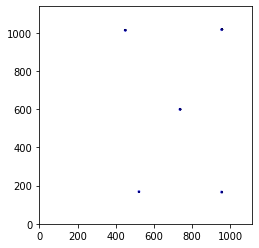

In [3]:
# Run DAOStarFinder to find sources in image

daofind = DAOStarFinder(fwhm=3.0, threshold=10.*std)    # default threshold=5*std, fwhm=3
sources = daofind(data)    
print(sources['xcentroid','ycentroid','peak'])   

# create apertures for sources

positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=4.)

# mark sources on image frame to see if the correct sources were found
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, cmap='Greys', origin='lower', vmin=0,vmax=20, norm=norm)
apertures.plot(color='blue', lw=1.5, alpha=0.5)
plt.show()


#### Put x, y coordinates into RA and Dec using the wcs information from the files.
The output of the next block of code should be a table showing the x and y centroid positions as well as the associated RA and Dec values.

In [4]:
# using wcs info from images, put coordinates into RA, Dec
ra, dec = im.meta.wcs(sources['xcentroid'], sources['ycentroid'])

# add RA, Dec to sources table

ra_col = Column(name='RA', data=ra)
dec_col = Column(name='Dec', data=dec)
sources.add_column(ra_col)
sources.add_column(dec_col)

# print RA, Dec for each x, y position found
print(sources['xcentroid', 'ycentroid', 'RA', 'Dec'])   


    xcentroid         ycentroid      ...           Dec          
----------------- ------------------ ... -----------------------
 953.727317871818  166.1681850252048 ...   -0.013338462166444904
521.0982001951338 168.40612727561526 ...   -0.013269478630660027
736.0652710471262  598.7929961543925 ... -2.9442501928795646e-06
 449.687020548392 1012.4796960670649 ...    0.012748812794109598
953.7404005848612 1016.7504162926165 ...    0.012880456071730433


#### Compare the RA and Dec positions used to create the simulated data to the values found in the output image.
Difference each set of RA and Dec coordinates in both the input list and the found coordinates, taking into account any angles close to 360/0 degrees. If the difference for both the RA and Dec are below a set tolerance, then the positions match. Take the matched positions and convert the differences from degrees to milli arcseconds, and output the RA and Dec positions as well as the differences. 

In [5]:
# Compare input RA, Dec to found RA, Dec
print('       RA found       Dec found    RA_Diff (mas)  Dec_diff (mas)')

for i in np.arange(0,len(RA_sim)):
    for j in np.arange(0,len(ra)):
        ra_diff = 180 - abs(abs(RA_sim[i] - ra[j])-180)
        dec_diff = 180 - abs(abs(Dec_sim[i] - dec[j])-180)

        if ra_diff < 1e-5 and dec_diff < 1e-5:
            # put differences in milliarcseconds
            ra_diff = ra_diff * 3600000
            dec_diff = dec_diff * 3600000
            print('{:15.6f} {:15.6f} {:15.6f} {:15.6f}'.format(ra[j], dec[j], ra_diff, dec_diff))


       RA found       Dec found    RA_Diff (mas)  Dec_diff (mas)
     359.993290       -0.013338        0.052928        2.815799
       0.006626       -0.013269        2.684439        8.692670
     359.999999       -0.000003        2.352124       10.599301
       0.008827        0.012749        2.899524        2.540859
     359.993290        0.012880        1.504383        3.826542


<a id="residual_ID"></a>
# Compare output RA and Dec to expected values

The output RA and Dec coordinates should match the input RA and Dec coordinates to within 1/10 of a PSF FWHM (~0.03 arcsec for F770W).

Output RA_Diff and Dec_diff above should be on order of 30 or fewer milliarcseconds.

[Top of Page](#title_ID)

<a id="about_ID"></a>
## About this Notebook
**Author:** M. Cracraft, Research and Instrument Scientist II, INS/MIRI
<br>**Updated On:** 05/17/2019

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 